<a href="https://colab.research.google.com/github/salilathalye/cwa-templates-pycaret/blob/main/CWA_Multiclass_Classification_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>Conversations with Austin</H1>
<h2>Multiclass Classifier Template
<p> Tested with PyCaret 2.2.3
<p>

Wait ... who is Austin, you ask? Austin the Apex Duck is my [Rubber Duck Debug buddy](https:en.wikipedia.org/wiki/Rubber_duck_debugging). Usually a pretty quiet type of guy, but I sense hidden depths of knowledge. Our chats usually start with me staring at something for a long time, then asking a question something like: "Hey Austin, what do you know about Kappa?". His usual response is: "Kappa? Tell me more, please". This usually starts a back and forth dialogue where he eggs (no pun intended!) me on to explain more. He's all about putting things in writing, which is why I'm sitting here taking notes which I'm cataloguing in a series called "Chats with Austin".

Salil Athalye
www.bokehboy.com


Data provided by [DPhi](https://dphi.tech//) Data Sprint #20: Human Memory and Cognition
https://dphi.tech/practice/challenge/56



# Configure Environment and Install Packages


In [1]:
!pip install pycaret==2.2.3 --quiet
!pip install mlflow --quiet
!pip install shap --quiet

     |████████████████████████████████| 256kB 1.3MB/s 
     |████████████████████████████████| 1.8MB 785kB/s 
     |████████████████████████████████| 102kB 609kB/s 
     |████████████████████████████████| 245kB 694kB/s 
     |████████████████████████████████| 14.2MB 208kB/s 
     |████████████████████████████████| 1.6MB 904kB/s 
     |████████████████████████████████| 157.5MB 96kB/s 
     |████████████████████████████████| 6.8MB 2.3MB/s 
     |████████████████████████████████| 174kB 3.8MB/s 
     |████████████████████████████████| 65.8MB 65kB/s 
     |████████████████████████████████| 276kB 4.0MB/s 
     |████████████████████████████████| 2.1MB 4.4MB/s 
     |████████████████████████████████| 604kB 6.9MB/s 
     |████████████████████████████████| 81kB 3.1MB/s 
     |████████████████████████████████| 3.1MB 4.1MB/s 
     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 153kB 4.7MB/s 
     |█████

# Import Libraries


In [2]:
from datetime import datetime
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import json
from google.colab import files


# PyCaret
import pycaret
from pycaret.classification import * 
from pycaret.utils import enable_colab
enable_colab()


# MLflow
import mlflow
#TODO: How to set up an MLflow server which we can use with Colab? 
#mlflow.set_tracking_uri('file:/c:/users/mlflow-server')

import shap
#TODO: Not sure how PyCaret sets up shap.initjs() which is required for CoLab.

Colab mode enabled.


# Set Experiment Parameters


In [3]:
EXPERIMENT_NAME = 'dphi_ch56_1'
SESSION_ID = 3435
DATA_SOURCE = "https://raw.githubusercontent.com/dphi-official/Datasets/master/hippocorpus"
TRAINING_DATA = "train_set_label.csv"
TEST_DATA = "test_set_label.csv"
TARGET_COL = 'memType'
# Set this to False when converting this notebook to a Productions script
VERBOSE = True
# Hyper-parameter search for model tuning
N_ITER = 5
# Should we download the run artifacts?
DOWNLOAD_ZIPFILE = True

In [4]:
MODEL = 'TBD' # we will populate this with the best model later

dt = datetime.now()
dt.replace(tzinfo=timezone.utc)
utc_timestamp = dt.replace(tzinfo=timezone.utc).isoformat(timespec='seconds')
# Replace ':' and '-' and retain up to seconds
UTC_TIMESTAMP = utc_timestamp.replace(':','').replace('-',"")[:15]

TRAINING_DATA_PATH = DATA_SOURCE + '/' + TRAINING_DATA
TEST_DATA_PATH = DATA_SOURCE + '/' + TEST_DATA

# Load the data


In [5]:
# Dataset is provided by DPhi
# raw.githubusercontent.com allows us to download 'raw' content of files stored on github

dtype_mapping = {}
training_data  = pd.read_csv(TRAINING_DATA_PATH, dtype=dtype_mapping)
test_data = pd.read_csv(TEST_DATA_PATH, dtype=dtype_mapping)

# Save the raw data in case the source is unavailable later
training_data.to_csv(TRAINING_DATA, index=False)
test_data.to_csv(TEST_DATA, index=False)
# Save any decisions we took on dtype mapping so we can reuse this in other applications
with open('dtype_mapping.json','w') as f:
  json.dump(dtype_mapping, f)

###Data Description
About the Data
The dataset contains short stories about recalled and imagined events.

These are the columns in the data:

- `AssignmentId`: Unique ID of this story

- `WorkTimeInSeconds`: Time in seconds that it took the worker to do the entire HIT (reading instructions, story writing, questions)

- `WorkerId`: Unique ID of the worker (random string, not MTurk worker ID)

- `annotatorAge`: Lower limit of the age bucket of the worker. Buckets are: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55+

- `annotatorGender`: Gender of the worker

- `annotatorRace`: Race/ethnicity of the worker

- `distracted`: How distracted were you while writing your story? (5-point Likert)

- `draining`: How taxing/draining was writing for you emotionally? (5-point Likert)

- `frequency`: How often do you think about or talk about this event? (5-point Likert)

- `importance`: How impactful, important, or personal is this story/event to you? (5-point Likert)

- `logTimeSinceEvent`: Log of time (days) since the recalled event happened

- `mainEvent`: Short phrase describing the main event described

- `memType`: Type of story (recalled, imagined, retold) - The target variable

- `mostSurprising`: Short phrase describing what the most surprising aspect of the story was

- `openness`: Continuous variable representing the openness to experience of the worker

- `recAgnPairId`: ID of the recalled story that corresponds to this retold story (null for imagined stories). Group on this variable to get the recalled-retold pairs.

- `recImgPairId`: ID of the recalled story that corresponds to this imagined story (null for retold stories). Group on this variable to get the recalled-imagined pairs.

- `similarity`: How similar to your life does this event/story feel to you? (5-point Likert)

- `similarityReason`: Free text annotation of similarity

- `story`: Story about the imagined or recalled event (15-25 sentences)

- `stressful`: How stressful was this writing task? (5-point Likert)

- `summary`: Summary of the events in the story (1-3 sentences)

- `timeSinceEvent`: Time (number of days) since the recalled event happened

<p>
Target: `mem_type`, {'retold' 'recalled' 'imagined'}




In [6]:
test_data.shape

(2057, 22)

In [7]:
training_data.shape

(6797, 23)

### Compare Training Data Columns to Test Data Columns

In [8]:
training_data.columns

Index(['AssignmentId', 'WorkTimeInSeconds', 'WorkerId', 'annotatorAge',
       'annotatorGender', 'annotatorRace', 'distracted', 'draining',
       'frequency', 'importance', 'logTimeSinceEvent', 'mainEvent',
       'mostSurprising', 'openness', 'recAgnPairId', 'recImgPairId',
       'similarity', 'similarityReason', 'story', 'stressful', 'summary',
       'timeSinceEvent', 'memType'],
      dtype='object')

In [9]:
test_data_columns = test_data.columns
training_data_columns = training_data.columns
#Set difference : columns in training_data that are not in test_data
columns_missing_in_test = set(training_data_columns) - set(test_data_columns)
print(columns_missing_in_test)

{'memType'}


In [10]:
training_data.head(5)

AssignmentId  WorkTimeInSeconds  WorkerId  annotatorAge  \
0  39DD6S19JQXBBJGPFEBWSF4G1TQEZJ               1025  YGROBIBW          35.0   
1  3WQQ9FUS6BGYKK3IWX9TEN1R8RLB87               1987  KK89LEHY          35.0   
2  3YDTZAI2WY2WOLYOIXQRRZ8DKXB14S               1604  JIWFAU5T          35.0   
3  3Q8GYXHFEQOY77CMCZYLDNXJ2YBC58               6369  1NHCDDOJ          40.0   
4  32AT8R96GMVVZ3RXAMWT04TG9CISU0               1083  A5SWJWSQ          30.0   

  annotatorGender annotatorRace distracted draining  frequency  importance  \
0             Man         white        one      3.0        2.0         3.0   
1           woman        indian        one      5.0        3.0         5.0   
2             man         White        one      one        5.0         5.0   
3           woman         white        one      one        NaN         4.0   
4             MAN         white        one      5.0        3.0         5.0   

   logTimeSinceEvent                                          mainEvent  \
0           4.094345  my friend's death and how our group of friends...   
1           5.010635  the loss of my father and the impact he had on...   
2           4.787492                                 how I met my wife.   
3           5.480639                the events leading up to my wedding   
4           4.094345                 Attending a funeral for my cousin.   

                                      mostSurprising  openness  \
0  the mourning process had a kind of positive si...     0.375   
1           he died very suddenly and within minutes     0.625   
2             when I got my unreserved kind of love.     1.000   
3              a surprise flash mob wedding proposal     0.875   
4       How emotional I felt during at the cemetery.     1.000   

                     recAgnPairId                    recImgPairId  similarity  \
0  3RKNTXVS3NKSI9BOEGJK201G4H2A46                             NaN         NaN   
1                             NaN  3WQQ9FUS6BGYKK3IWX9TEN1R8RLB87         NaN   
2                             NaN  3YDTZAI2WY2WOLYOIXQRRZ8DKXB14S         NaN   
3                             NaN  3WLEIWSYHP3XPI4FG8AOQ7RM04VH26         1.0   
4                             NaN  32AT8R96GMVVZ3RXAMWT04TG9CISU0         NaN   

                                    similarityReason  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  This was not at all how I got engaged, but a w...   
4                                                NaN   

                                               story  stressful  \
0  We were friends from high school. I got a call...        3.0   
1  Five months ago, my father passed away from a ...        2.0   
2  My Most Memorable Day of My Life! I found my o...        1.0   
3  It has been such a whirlwind these past 8 mont...        1.0   
4  Today was one of the saddest days of my life. ...        4.0   

                                             summary  timeSinceEvent   memType  
0  my friend's death. Old friends reunited to sha...            60.0    retold  
1  My dad, who was a significant person in my lif...           150.0  recalled  
2  The best thing may be difficult to find. I was...           120.0  recalled  
3  The event described details my wedding which o...           240.0  imagined  
4  My cousin recently passed away due to brain ca...            60.0  recalled

In [11]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6797 entries, 0 to 6796
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AssignmentId       6797 non-null   object 
 1   WorkTimeInSeconds  6797 non-null   int64  
 2   WorkerId           6797 non-null   object 
 3   annotatorAge       6771 non-null   float64
 4   annotatorGender    6793 non-null   object 
 5   annotatorRace      6797 non-null   object 
 6   distracted         6797 non-null   object 
 7   draining           6797 non-null   object 
 8   frequency          4052 non-null   float64
 9   importance         6649 non-null   float64
 10  logTimeSinceEvent  6797 non-null   float64
 11  mainEvent          6797 non-null   object 
 12  mostSurprising     6797 non-null   object 
 13  openness           6797 non-null   float64
 14  recAgnPairId       2549 non-null   object 
 15  recImgPairId       5303 non-null   object 
 16  similarity         2745 

In [12]:
training_data.isna().sum()

AssignmentId            0
WorkTimeInSeconds       0
WorkerId                0
annotatorAge           26
annotatorGender         4
annotatorRace           0
distracted              0
draining                0
frequency            2745
importance            148
logTimeSinceEvent       0
mainEvent               0
mostSurprising          0
openness                0
recAgnPairId         4248
recImgPairId         1494
similarity           4052
similarityReason     4052
story                   0
stressful               0
summary                 0
timeSinceEvent          0
memType                 0
dtype: int64

In [13]:
training_data.describe()

WorkTimeInSeconds  annotatorAge    frequency   importance  \
count        6797.000000   6771.000000  4052.000000  6649.000000   
mean         2072.577166     33.513661     3.643633     3.958941   
std          1670.981846     10.152089     1.029724     1.261159   
min           173.000000     18.000000     1.000000     1.000000   
25%           919.000000     25.000000     3.000000     3.000000   
50%          1524.000000     30.000000     4.000000     4.000000   
75%          2632.000000     40.000000     4.000000     5.000000   
max         10680.000000     55.000000     5.000000     5.000000   

       logTimeSinceEvent     openness   similarity    stressful  \
count        6797.000000  6797.000000  2745.000000  6797.000000   
mean            7.145193     0.554252     2.929326     2.161395   
std            13.854228     0.423053     1.446355     1.322928   
min             1.945910    -1.000000     1.000000     1.000000   
25%             3.555348     0.250000     2.000000     1.000000   
50%             4.499810     0.625000     3.000000     2.000000   
75%             5.010635     0.875000     4.000000     3.000000   
max           136.818082     1.000000     5.000000     5.000000   

       timeSinceEvent  
count    6.797000e+03  
mean     3.938160e+56  
std      8.718221e+57  
min      7.000000e+00  
25%      3.500000e+01  
50%      9.000000e+01  
75%      1.500000e+02  
max      2.626263e+59

In [14]:
training_data[TARGET_COL].value_counts()

recalled    2760
imagined    2745
retold      1292
Name: memType, dtype: int64

In [15]:
for n in training_data.select_dtypes(include='object'):
  unique_values = training_data[n].unique()
  unique_count = len(unique_values)
  print(f'Column {n} | {unique_count}: {unique_values}')

Column AssignmentId | 4797: ['39DD6S19JQXBBJGPFEBWSF4G1TQEZJ' '3WQQ9FUS6BGYKK3IWX9TEN1R8RLB87'
 '3YDTZAI2WY2WOLYOIXQRRZ8DKXB14S' ... '3Q5C1WP23NNEK42OW291WRERBKH15H'
 '3ZY8KE4ISKPJZ21KN8HT1QGZJ1EQVY' '3SEPORI8WOL8L6ZDZ99AWWEPPZGZAC']
Column WorkerId | 2942: ['YGROBIBW' 'KK89LEHY' 'JIWFAU5T' ... 'VD55ALFB' 'AF0EZKOL' '0Q6SN9VL']
Column annotatorGender | 17: ['Man' 'woman' 'man' 'MAN' 'WOMAN' 'Woman' 'na' 'Nonbinary' 'transman'
 'Transman' 'Na' 'nonBinary' 'TRANSMAN' nan 'Transwoman' 'other'
 'NONBINARY']
Column annotatorRace | 20: ['white' 'indian' 'White' 'Asian' 'black' 'native' 'Other' 'Black' 'hisp'
 'asian' 'other' 'Middleeastern' 'na' 'Hisp' 'Indian' 'Native' 'Na'
 'middleEastern' 'Islander' 'islander']
Column distracted | 5: ['one' '2.0' '4.0' '3.0' '5.0']
Column draining | 5: ['3.0' '5.0' 'one' '2.0' '4.0']
Column mainEvent | 4537: ["my friend's death and how our group of friends reminisced"
 'the loss of my father and the impact he had on our family.'
 'how I met my wife.' ...


# Perform Basic Exploratory Data Analysis


# Set up the Experiment
### Notes
* Only set silent=True when you are sure that PyCaret has interpreted the type of each feature correctly. Also remember that if use the default (silent=False), **PyCaret will pause here**, waiting for user confirmation!!!
* When you migrate to Production in the form of a Python script then set html=False.


In [16]:
experiment = setup(training_data, 
                    target = TARGET_COL, 
                    session_id=SESSION_ID, 
                    ignore_features=['WorkerId','AssignmentId','mainEvent','mostSurprising', 'similarityReason', 'similarity','recAgnPairId','recImgPairId','timeSinceEvent','summary','story'],
                    numeric_features=['WorkTimeInSeconds','annotatorAge','frequency','importance','logTimeSinceEvent','openness','stressful','timeSinceEvent'],
                    imputation_type="iterative", 
                    categorical_iterative_imputer="lightgbm", 
                    numeric_iterative_imputer="lightgbm", 
                    iterative_imputation_iters = 5,
                    normalize = True,
                    fix_imbalance = True,
                    fix_imbalance_method = None, # will use SMOTE when set to None
                    fold_strategy='stratifiedkfold',
                    log_experiment = True,       # sets up MLflow using local files
                    log_plots=True,
                    log_profile=True,
                    log_data=True,
                    experiment_name = EXPERIMENT_NAME,
                    silent=True,                 # set to True only when you confirm feature types selected by PyCaret
                    #html=False                  # set to False when converting this to a Production script
                   )

Description                                Value
0                               session_id                                 3435
1                                   Target                              memType
2                              Target Type                           Multiclass
3                            Label Encoded  imagined: 0, recalled: 1, retold: 2
4                            Original Data                           (6797, 23)
5                           Missing Values                                 True
6                         Numeric Features                                    7
7                     Categorical Features                                    4
8                         Ordinal Features                                False
9                High Cardinality Features                                False
10                 High Cardinality Method                                 None
11                   Transformed Train Set                           (4757, 52)
12                    Transformed Test Set                           (2040, 52)
13                      Shuffle Train-Test                                 True
14                     Stratify Train-Test                                False
15                          Fold Generator                      StratifiedKFold
16                             Fold Number                                   10
17                                CPU Jobs                                   -1
18                                 Use GPU                                False
19                          Log Experiment                                 True
20                         Experiment Name                          dphi_ch56_1
21                                     USI                                 18ef
22                         Imputation Type                            iterative
23          Iterative Imputation Iteration                                    5
24                         Numeric Imputer                                 mean
25      Iterative Imputation Numeric Model      Light Gradient Boosting Machine
26                     Categorical Imputer                             constant
27  Iterative Imputation Categorical Model      Light Gradient Boosting Machine
28           Unknown Categoricals Handling                       least_frequent
29                               Normalize                                 True
30                        Normalize Method                               zscore
31                          Transformation                                False
32                   Transformation Method                                 None
33                                     PCA                                False
34                              PCA Method                                 None
35                          PCA Components                                 None
36                     Ignore Low Variance                                False
37                     Combine Rare Levels                                False
38                    Rare Level Threshold                                 None
39                         Numeric Binning                                False
40                         Remove Outliers                                False
41                      Outliers Threshold                                 None
42                Remove Multicollinearity                                False
43             Multicollinearity Threshold                                 None
44                              Clustering                                False
45                    Clustering Iteration                                 None
46                     Polynomial Features                                False
47                       Polynomial Degree                                 None
48                    Trignometry Features                                False
49                    Polynomia

Finished loading model, total used 91 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


#PyCaret Pipeline
PyCaret creates a Pipeline behind the scenes. Using get_config() we can output a description of the steps in the Pipeline.
<p>
TODO: Figure out how to save the pipeline description to JSON, perhaps?

In [17]:
prep_pipe = get_config('prep_pipe')

In [18]:
prep_pipe

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['WorkerId',
                                                       'AssignmentId',
                                                       'mainEvent',
                                                       'mostSurprising',
                                                       'similarityReason',
                                                       'similarity',
                                                       'recAgnPairId',
                                                       'recImgPairId',
                                                       'timeSinceEvent',
                                                       'summary', 'story'],
                                      id_columns=[],
                                      ml_usecase='classificati

# Feature Transformations
Review how PyCaret has transformed Features and the Target looking only at the training data to avoid data leakage.
This is useful when we start developing the front-end and the API so we can be specific on what categorical values are allowed.
<p>
TODO: Seems like we have to infer what transformations were made to each Feature. Would like to see something like col_a was Normalized, col_b was One Hot Encoded etc.

In [19]:
transformed_training_features = get_config('X_train')

In [20]:
transformed_training_features.T[0]

WorkTimeInSeconds              -0.622660
annotatorAge                   35.000000
frequency                       2.000000
importance                      3.000000
logTimeSinceEvent              -0.220031
openness                       -0.411539
stressful                       0.638000
annotatorGender_MAN             0.000000
annotatorGender_Man             1.000000
annotatorGender_NONBINARY       0.000000
annotatorGender_Na              0.000000
annotatorGender_Nonbinary       0.000000
annotatorGender_TRANSMAN        0.000000
annotatorGender_Transman        0.000000
annotatorGender_Transwoman      0.000000
annotatorGender_WOMAN           0.000000
annotatorGender_Woman           0.000000
annotatorGender_man             0.000000
annotatorGender_na              0.000000
annotatorGender_nonBinary       0.000000
annotatorGender_transman        0.000000
annotatorGender_woman           0.000000
annotatorRace_Asian             0.000000
annotatorRace_Black             0.000000
annotatorRace_Hi

#Evaluate, Select and Tune Model

## Compare Models


In [21]:
# return best model based on F1
best = compare_models(sort = 'F1', fold=5) #default is 'Accuracy'

Model  Accuracy     AUC  Recall   Prec.  \
xgboost         Extreme Gradient Boosting    0.9062  0.9736  0.8701  0.9049   
lightgbm  Light Gradient Boosting Machine    0.9060  0.9735  0.8682  0.9046   
catboost              CatBoost Classifier    0.8999  0.9716  0.8626  0.8985   
gbc          Gradient Boosting Classifier    0.8823  0.9665  0.8425  0.8811   
rf               Random Forest Classifier    0.8631  0.9569  0.8256  0.8609   
dt               Decision Tree Classifier    0.8543  0.8942  0.8213  0.8582   
et                 Extra Trees Classifier    0.7870  0.9294  0.7428  0.7853   
ada                  Ada Boost Classifier    0.7561  0.9260  0.7661  0.8422   
lr                    Logistic Regression    0.5730  0.7737  0.5635  0.6099   
ridge                    Ridge Classifier    0.5701  0.0000  0.5541  0.6097   
lda          Linear Discriminant Analysis    0.5602  0.7637  0.5546  0.6184   
knn                K Neighbors Classifier    0.5602  0.7597  0.5516  0.5926   
svm                   SVM - Linear Kernel    0.4692  0.0000  0.4585  0.6618   
nb                            Naive Bayes    0.2966  0.6980  0.4106  0.6017   
qda       Quadratic Discriminant Analysis    0.2731  0.6857  0.3966  0.6443   

              F1   Kappa     MCC  TT (Sec)  
xgboost   0.9049  0.8516  0.8522     7.812  
lightgbm  0.9044  0.8511  0.8519     0.634  
catboost  0.8984  0.8416  0.8423    15.388  
gbc       0.8813  0.8141  0.8145     2.864  
rf        0.8608  0.7828  0.7837     1.090  
dt        0.8560  0.7717  0.7720     0.146  
et        0.7827  0.6597  0.6622     1.092  
ada       0.7764  0.6378  0.6611     0.462  
lr        0.5847  0.3518  0.3568     3.168  
ridge     0.5836  0.3473  0.3519     0.124  
lda       0.5777  0.3411  0.3497     0.156  
knn       0.5671  0.3310  0.3368     0.384  
svm       0.4202  0.1948  0.2685     0.434  
nb        0.2566  0.0901  0.1616     0.126  
qda       0.2053  0.0735  0.1561     0.138

In [22]:
compare_model_results = pull()
compare_model_results.to_csv('compare_model.csv', index=False)

## Select the Base Model
### Notes for Austin
* Austin, when we want to study the decision boundaries that are established by different types of models, we can use create_model to run these experiments.

### Do your research!
* Future iteration, let's get a top N set of models that we can use for a bagging,blending,stacking foray! What would be a good criteria for going down this path? Can we establish a parallel path, or perhaps a choice?

In [23]:
# Get the name of the best model, based on criteria provided above
MODEL = compare_model_results.index[0]

In [24]:
# train base model
base_model = create_model(MODEL, verbose=True)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9013  0.9744  0.8651  0.9000  0.9003  0.8438  0.8442
1       0.9223  0.9791  0.9021  0.9231  0.9226  0.8779  0.8780
2       0.9034  0.9697  0.8631  0.9023  0.9014  0.8465  0.8477
3       0.9286  0.9787  0.9004  0.9277  0.9277  0.8871  0.8875
4       0.9055  0.9713  0.8754  0.9047  0.9050  0.8511  0.8512
5       0.9076  0.9780  0.8657  0.9072  0.9050  0.8530  0.8551
6       0.9055  0.9690  0.8678  0.9038  0.9037  0.8503  0.8510
7       0.9116  0.9816  0.8895  0.9130  0.9122  0.8613  0.8614
8       0.9074  0.9743  0.8684  0.9062  0.9056  0.8530  0.8541
9       0.9242  0.9821  0.8960  0.9233  0.9235  0.8803  0.8805
Mean    0.9117  0.9758  0.8794  0.9111  0.9107  0.8604  0.8611
SD      0.0092  0.0045  0.0150  0.0095  0.0096  0.0148  0.0145

In [25]:
create_model_results = pull()
create_model_results.to_csv('create_model.csv', index=False)

## Tune the Model


In [26]:
# tune hyperparameters to optimize F1
tuned_model = tune_model(base_model, optimize = 'F1', n_iter=N_ITER)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9013  0.9760  0.8652  0.9003  0.9003  0.8438  0.8443
1       0.9055  0.9813  0.8725  0.9046  0.9048  0.8507  0.8509
2       0.8971  0.9728  0.8540  0.8962  0.8949  0.8364  0.8380
3       0.9307  0.9792  0.8983  0.9305  0.9292  0.8901  0.8913
4       0.9181  0.9777  0.8917  0.9177  0.9178  0.8710  0.8711
5       0.9160  0.9802  0.8746  0.9158  0.9133  0.8663  0.8685
6       0.9097  0.9701  0.8693  0.9083  0.9073  0.8565  0.8580
7       0.9263  0.9841  0.9057  0.9267  0.9265  0.8842  0.8842
8       0.9074  0.9743  0.8625  0.9064  0.9044  0.8524  0.8546
9       0.9221  0.9848  0.8924  0.9213  0.9213  0.8768  0.8772
Mean    0.9134  0.9781  0.8786  0.9128  0.9120  0.8628  0.8638
SD      0.0105  0.0045  0.0163  0.0108  0.0109  0.0168  0.0166

In [27]:
tune_model_results = pull()
tune_model_results.to_csv('tune_model.csv', index=False)

## Review Model Diagnostics
### Notes for Austin
* This is where we need to spend some quality time. Surfacing the insights from a set of runs to inform our next choices. Especially true when you are running complex models on cloud clusters --- the $$$ start to rack up.
* Let's invest in a deep study of these plots and formulate an approach

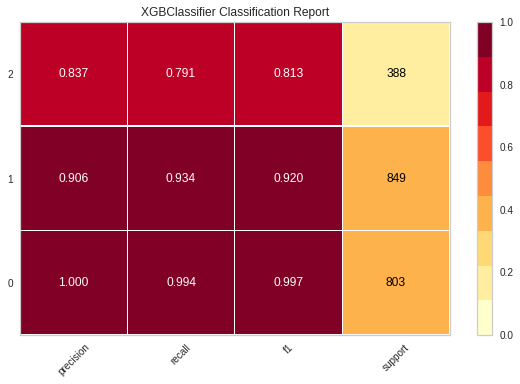

In [28]:
plot_model(tuned_model, plot = 'class_report')

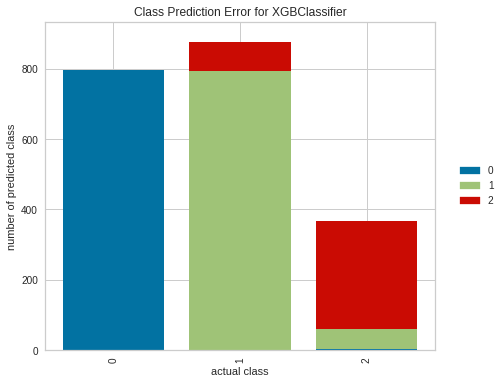

In [29]:
plot_model(tuned_model, plot='error')

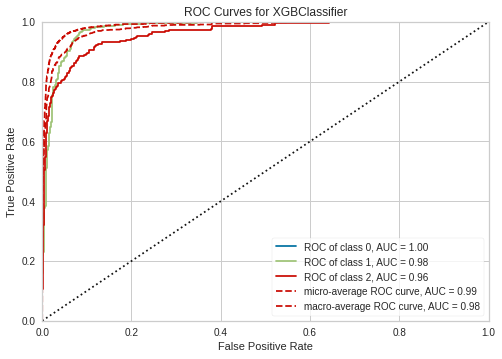

In [30]:
#plot a model
plot_model(tuned_model, plot='auc')

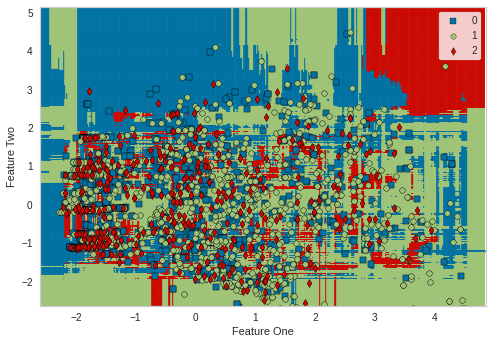

In [31]:
plot_model(tuned_model, plot='boundary')

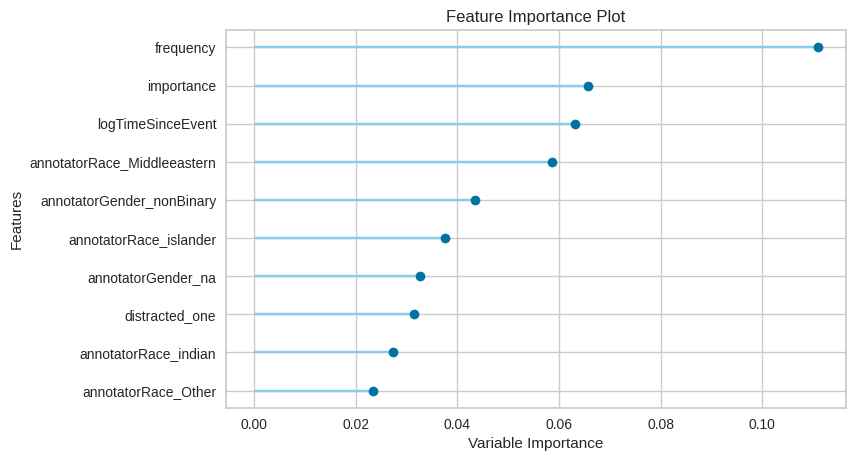

In [32]:

plot_model(tuned_model, plot='feature')

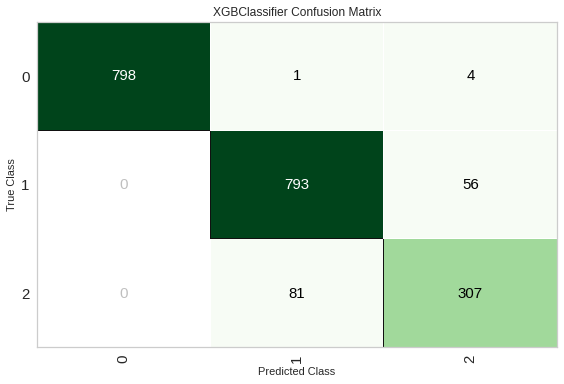

In [33]:
plot_model(tuned_model, plot = 'confusion_matrix')

In [34]:
predict_model(tuned_model)

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Extreme Gradient Boosting    0.9304  0.9838  ...  0.9299  0.8901  0.8903

[1 rows x 8 columns]

WorkTimeInSeconds  annotatorAge  frequency  ...   memType     Label   Score
0              2.158166          18.0   3.690566  ...  imagined  imagined  0.9853
1             -0.910872          40.0   2.000000  ...    retold  recalled  0.7398
2              2.910654          35.0   4.000000  ...  recalled  recalled  0.5264
3             -0.940417          30.0   3.408482  ...  imagined  imagined  0.9923
4             -0.342286          45.0   4.000000  ...    retold    retold  0.8433
...                 ...           ...        ...  ...       ...       ...     ...
2035          -0.082412          40.0   5.000000  ...  recalled  recalled  0.9914
2036          -0.266917          35.0   2.157894  ...  imagined  imagined  0.9981
2037           0.146107          35.0   4.000000  ...    retold    retold  0.8338
2038           0.050238          30.0   3.000000  ...  recalled  recalled  0.9490
2039          -0.781840          35.0   5.000000  ...  recalled  recalled  0.9565

[2040 rows x 55 columns]

##Interpret Model Predictions
<p>
If you are viewing this notebook on github, the next set of plots will not render as they require Javascript. SHAP interpretation

In [35]:
shap_models = ['xgboost', 'rf', 'catboost', 'et', 'lightgbm', 'dt']
run_shap = True if MODEL in shap_models else False
print(f'Cannot run SHAP model interpretation for {MODEL}' if run_shap == False else 'Running SHAP model interpretation. Plots require Javascript and may not render on github')

Running SHAP model interpretation. Plots require Javascript and may not render on github


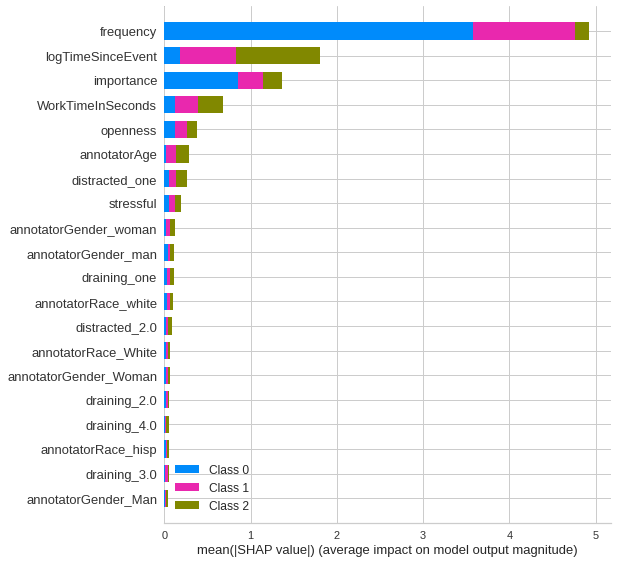

In [36]:
if run_shap:
  interpret_model(tuned_model)

## Finalize the Model

In [37]:
final_model = finalize_model(tuned_model)

Finished loading model, total used 91 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


In [38]:
print(final_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.046, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=220, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=3435, reg_alpha=0.0001,
              reg_lambda=0.1, scale_pos_weight=41.400000000000006,
              subsample=0.7, tree_method='auto', use_label_encoder=True,
              validate_parameters=1, verbosity=0)


In [39]:
FINAL_MODEL_NAME_WITH_TS = EXPERIMENT_NAME + '_' + MODEL + '_' + UTC_TIMESTAMP
FINAL_MODEL_NAME_WITHOUT_TS = EXPERIMENT_NAME + '_' + MODEL

* Not sure if there are issues with putting a timestamp or a file name length constraint for cloud environments. I recall that Azure Machine Learning had an experiment name string length limit. For now, I will save the model again with a simple file name without the timestamp.

In [40]:
save_model(final_model, FINAL_MODEL_NAME_WITHOUT_TS)

Finished loading model, total used 91 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['WorkerId',
                                                        'AssignmentId',
                                                        'mainEvent',
                                                        'mostSurprising',
                                                        'similarityReason',
                                                        'similarity',
                                                        'recAgnPairId',
                                                        'recImgPairId',
                                                        'timeSinceEvent',
                                                        'summary', 'story'],
                                       id_columns=[],
                                       ml_useca

In [41]:
save_model(final_model, FINAL_MODEL_NAME_WITH_TS)

Finished loading model, total used 91 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['WorkerId',
                                                        'AssignmentId',
                                                        'mainEvent',
                                                        'mostSurprising',
                                                        'similarityReason',
                                                        'similarity',
                                                        'recAgnPairId',
                                                        'recImgPairId',
                                                        'timeSinceEvent',
                                                        'summary', 'story'],
                                       id_columns=[],
                                       ml_useca

In [42]:
!ls

catboost_info				 logs.log
compare_model.csv			 mlruns
create_model.csv			 sample_data
dphi_ch56_1_xgboost_20210115T124041.pkl  test_set_label.csv
dphi_ch56_1_xgboost.pkl			 train_set_label.csv
dtype_mapping.json			 tune_model.csv


# Load Model and Predict


In [43]:
loaded_model = load_model(FINAL_MODEL_NAME_WITHOUT_TS)

Transformation Pipeline and Model Successfully Loaded


In [44]:
loaded_model

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['WorkerId',
                                                       'AssignmentId',
                                                       'mainEvent',
                                                       'mostSurprising',
                                                       'similarityReason',
                                                       'similarity',
                                                       'recAgnPairId',
                                                       'recImgPairId',
                                                       'timeSinceEvent',
                                                       'summary', 'story'],
                                      id_columns=[],
                                      ml_usecase='classificati

In [45]:
single_example = test_data.iloc[[1],:]

In [46]:
single_example.head()

AssignmentId  ...  timeSinceEvent
1  3C8HJ7UOP8G9N782WCZF5N9PDLQMZ8  ...           120.0

[1 rows x 22 columns]

In [47]:
single_example.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1 to 1
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AssignmentId       1 non-null      object 
 1   WorkTimeInSeconds  1 non-null      int64  
 2   WorkerId           1 non-null      object 
 3   annotatorAge       1 non-null      float64
 4   annotatorGender    1 non-null      object 
 5   annotatorRace      1 non-null      object 
 6   distracted         1 non-null      object 
 7   draining           1 non-null      object 
 8   frequency          1 non-null      float64
 9   importance         1 non-null      float64
 10  logTimeSinceEvent  1 non-null      float64
 11  mainEvent          1 non-null      object 
 12  mostSurprising     1 non-null      object 
 13  openness           1 non-null      float64
 14  recAgnPairId       1 non-null      object 
 15  recImgPairId       0 non-null      object 
 16  similarity         0 non-null 

In [48]:
prediction = predict_model(loaded_model, data= single_example)

In [49]:
prediction

AssignmentId  WorkTimeInSeconds  ...     Label   Score
1  3C8HJ7UOP8G9N782WCZF5N9PDLQMZ8               1392  ...  recalled  0.8187

[1 rows x 24 columns]

In [50]:
batch_prediction = predict_model(loaded_model, data=test_data)

In [51]:
batch_prediction

AssignmentId  WorkTimeInSeconds  ...     Label   Score
0     386PBUZZXGJZHALDEEVEHG6BE9EJLD               4679  ...  imagined  0.9921
1     3C8HJ7UOP8G9N782WCZF5N9PDLQMZ8               1392  ...  recalled  0.8187
2     3WR9XG3T64XAZ7DQ7D70S9ZQCVZ47T               1321  ...  recalled  0.9984
3     3VD82FOHKRAKFHI4HEUKMTX9CYJOCT               1583  ...    retold  0.9319
4     37TD41K0AIVZD9AXOVBT6Y7AR0OSC4                920  ...  imagined  0.8217
...                              ...                ...  ...       ...     ...
2052  3R0T90IZ1TYWN416TVHCHKO7LARCGP                501  ...  recalled  0.8062
2053  3U8YCDAGXQ236104KBT4GXQ820IQ0O               1376  ...  recalled  0.9771
2054  31QNSG6A5SFBI80SJGXD9LFV7D9782               2862  ...  imagined  0.9970
2055  3D4CH1LGEBFUP6U3HB7LFUNZQG89GI               1025  ...    retold  0.7927
2056  3TXMY6UCAFAN0TVKWRMOBYS9ALWCQB                711  ...  recalled  0.5255

[2057 rows x 24 columns]

In [52]:
submission = batch_prediction[['Label']]
submission.rename(columns={'Label':'prediction'}, inplace=True)
submission.index = test_data.index
submission.to_csv('prediction_results.csv', index=False)

In [53]:
logs = get_logs(save=True)
logs.head()

run_id  ... tags.USI
0  015adb6c402348b99c484c1933bc12cf  ...     18ef
1  a5bebf7e34024d9c9c4bfb4554a65d59  ...     18ef
2  4cb42e58c6f54efe94e6a8dde6c86c29  ...     18ef
3  057b8a2519274859aeeaec695bf60eba  ...     18ef
4  10cf460468d749f28f33c469a7d7b29e  ...     18ef

[5 rows x 173 columns]

# Capture Schema Information



In [54]:
import json

def schema_to_json(df, filename_prefix):
  '''
  Adapted from
  Source: https://stackoverflow.com/questions/50422404/save-and-export-dtypes-information-of-a-python-pandas-dataframe
  '''
  columns_filename = filename_prefix + '_columns.json'
  df.head(0).to_json(columns_filename)

  tmp = df.dtypes.to_frame('dtypes').reset_index()
  df_dtypes = tmp.set_index('index')['dtypes'].astype(str).to_dict()
  dtypes_filename = filename_prefix + '_dtypes.json'
  with open(dtypes_filename, 'w') as f:
    json.dump(df_dtypes, f)

In [55]:
schema_to_json(training_data, 'training_data')
schema_to_json(test_data, 'test_data')

# Capture Package Versions


In [56]:
'''
Adapted from
Source: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
'''
package_versions = {m.__name__ : m.__version__ for m in globals().values() if getattr(m, '__version__', None)}
with open('notebook_package_versions.json','w') as f:
  json.dump(package_versions, f)

# Bundle Outputs and Download

In [57]:
# Google Colab places a folder of sample data in sample_data. We don't need that.
!rm -rf sample_data ||:

In [58]:
ZIP_ARCHIVE_NAME = FINAL_MODEL_NAME_WITH_TS + '.zip'

In [59]:
!zip -qr ./$ZIP_ARCHIVE_NAME ./

In [60]:
if DOWNLOAD_ZIPFILE:
  files.download(ZIP_ARCHIVE_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>